# SQL in Data Science

PostgreSQL lets you build queries which run a variety of [machine learning algorithms](https://www.postgresql.org/docs/13/functions-aggregate.html) against your data.

* [Source: Machine Learning Directly in SQL – How to Use ML in Databases](https://www.freecodecamp.org/news/machine-learning-directly-in-sql/)

In [18]:
import psycopg2
from config import config
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Dataset

In [1]:
!wget https://gist.github.com/Thanatoz-1/9e7fdfb8189f0cdf5d73a494e4a6392a/raw/aaecbd14aeaa468cd749528f291aa8a30c2ea09e/iris_dataset.csv

--2023-07-02 19:50:26--  https://gist.github.com/Thanatoz-1/9e7fdfb8189f0cdf5d73a494e4a6392a/raw/aaecbd14aeaa468cd749528f291aa8a30c2ea09e/iris_dataset.csv
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving gist.github.com (gist.github.com)... 20.27.177.113
Connecting to gist.github.com (gist.github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://gist.githubusercontent.com/Thanatoz-1/9e7fdfb8189f0cdf5d73a494e4a6392a/raw/aaecbd14aeaa468cd749528f291aa8a30c2ea09e/iris_dataset.csv [following]
--2023-07-02 19:50:27--  https://gist.githubusercontent.com/Thanatoz-1/9e7fdfb8189f0cdf5d73a494e4a6392a/raw/aaecbd14aeaa468cd749528f291aa8a30c2ea09e/iris_dataset.csv
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, await

In [45]:
data_iris = pd.read_csv ('iris_dataset.csv')   
df_iris = pd.DataFrame(data_iris)
df_iris.rename(columns={
    'sepal length (cm)': 'sepal_length',
    'sepal width (cm)': 'sepal_width',
    'petal length (cm)': 'petal_length',
    'petal width (cm)': 'petal_width',
}, inplace=True)
df_iris.head(5)

,sepal_length,sepal_width,petal_length,petal_width,target
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


|   | sepal_length | sepal_width | petal_length | petal_width | target |
| -- | -- | -- | -- | -- | -- |
| 0 | 5.1 | 3.5 | 1.4 | 0.2 | Iris-setosa |
| 1 | 4.9 | 3.0 | 1.4 | 0.2 | Iris-setosa |
| 2 | 4.7 | 3.2 | 1.3 | 0.2 | Iris-setosa |
| 3 | 4.6 | 3.1 | 1.5 | 0.2 | Iris-setosa |
| 4 | 5.0 | 3.6 | 1.4 | 0.2 | Iris-setosa |

In [50]:
def create_table():
    conn = None
    try:
        # read database configuration
        params = config()
        # connect to the PostgreSQL database
        conn = psycopg2.connect(**params)
        # create a new cursor
        cursor = conn.cursor()
        # create the table
        cursor.execute('''
        CREATE TABLE iris (
            index SMALLINT primary key,
            sepal_length FLOAT,
            sepal_width FLOAT,
            petal_length FLOAT,
            petal_width FLOAT,
            target VARCHAR
            )
               ''')
        conn.commit()
        # Close communication with the PostgreSQL database
        cursor.close()
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)

In [52]:
def add_data():
    conn = None
    try:
        # read database configuration
        params = config()
        # connect to the PostgreSQL database
        conn = psycopg2.connect(**params)
        # create a new cursor
        cursor = conn.cursor()
        # insert data
        for row in df_iris.itertuples():
            cursor.execute('''
                INSERT INTO iris (
                    index, sepal_length, sepal_width, petal_length, petal_width, target
                ) VALUES (
                    %s, %s, %s, %s, %s, %s
                    )''',
                (
                    row.Index,
                    row.sepal_length,
                    row.sepal_width,
                    row.petal_length,
                    row.petal_width,
                    row.target
                )
            )
        # Commit the changes to the database
        conn.commit()
        # Close communication with the PostgreSQL database
        cursor.close()
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)

In [54]:
create_table()
add_data()

## Linear Regression

In [109]:
query = f"""
WITH regression AS
  (SELECT 
      regr_slope(petal_width, petal_length) AS gradient,
      regr_intercept(petal_width, petal_length) AS intercept
   FROM
      iris
   WHERE
      petal_width IS NOT NULL
   )

SELECT
   petal_length,
   (petal_length * gradient) + intercept AS prediction
FROM
   iris
CROSS JOIN
   regression
WHERE
   petal_width IS NOT NULL ;
"""

In [103]:
def linear_regression(query):
    conn = None
    try:
        params = config()
        conn = psycopg2.connect(**params)
        cursor = conn.cursor()
        query = query
        cursor.execute(query)
        results = cursor.fetchall()

        cursor.close()
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            return(results)
            conn.close()

In [110]:
results = linear_regression(query=query)

In [111]:
df_pred = pd.DataFrame(results, columns=['petal_length', 'petal_width_pred'])
df_pred.head()

,petal_length,petal_width_pred
0,1.4,0.216473
1,1.4,0.216473
2,1.3,0.174831
3,1.5,0.258115
4,1.4,0.216473


|  | petal_length | petal_width_pred |
| -- | -- | -- |
| 0 | 1.4 | 0.216473 |
| 1 | 1.4 | 0.216473 |
| 2 | 1.3 | 0.174831 |
| 3 | 1.5 | 0.258115 |
| 4 | 1.4 | 0.216473 |

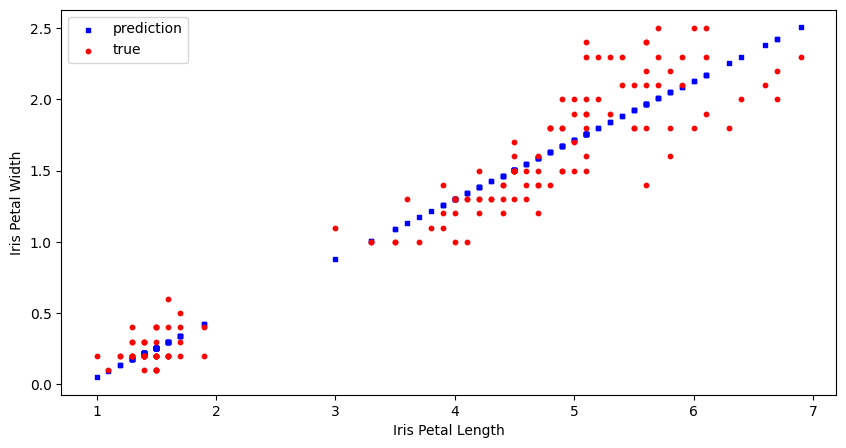

In [117]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)

ax1.scatter(data=df_pred, x='petal_length', y='petal_width_pred', s=10, c='b', marker="s", label='prediction')
ax1.scatter(data=df_iris, x='petal_length', y='petal_width', s=10, c='r', marker="o", label='true')
plt.legend(loc='upper left')
plt.xlabel('Iris Petal Length')
plt.ylabel('Iris Petal Width')

plt.savefig('assets/sql-for-data-science_01.webp', bbox_inches='tight')

![SQL in Data Science](./assets/sql-for-data-science_01.webp)

## K-Nearest Neighbours

In [129]:
query = f'''
-- CTE to get labelled training data
WITH training AS
  (SELECT
      index,
      POINT(sepal_length, petal_length) as xy,
      target
  FROM
      iris
  WHERE
      target IS NOT NULL
  ),

-- CTE to get the unlabelled points
test AS
  (SELECT
      index,
      POINT(sepal_length, petal_length) as xy,
      target
  FROM
      iris
  WHERE
      target IS NOT NULL
  ),

-- calculate distances between unlabelled & labelled points
distances AS
  (SELECT
      test.index,
      training.target,
      test.xy <-> training.xy AS dist,
      ROW_NUMBER() OVER (
         PARTITION BY test.index
         ORDER BY test.xy <-> training.xy 
         ) AS row_no
  FROM
      test
  CROSS JOIN training
  ORDER BY 1, 4 ASC
  ),

-- count the 'votes' per label for each unlabelled point
votes AS
  (SELECT
      index,
      target,
      count(*) AS votes
  FROM distances
  WHERE row_no <= 5
  GROUP BY 1,2
  ORDER BY 1)

-- query for the label with the most votes
SELECT
  v.index,
  v.target
FROM
  votes v
JOIN
  (SELECT
      index,
      max(votes) AS max_votes
  FROM
      votes
  GROUP BY 1
  ) mv 
ON v.index = mv.index
AND v.votes = mv.max_votes
ORDER BY 1 ASC ;
'''

In [130]:
def k_nearest_neighbours(query):
    conn = None
    try:
        params = config()
        conn = psycopg2.connect(**params)
        cursor = conn.cursor()
        query = query
        cursor.execute(query)
        results = cursor.fetchall()

        cursor.close()
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            return(results)
            conn.close()

In [131]:
# run training with k=5
results = k_nearest_neighbours(query=query)

In [135]:
df_pred = pd.DataFrame(results, columns=['index', 'target_pred'])
df_pred.head()

,index,target_pred
0,0,Iris-setosa
1,1,Iris-setosa
2,2,Iris-setosa
3,3,Iris-setosa
4,4,Iris-setosa


|  | index | target_pred |
| -- | -- | -- |
| 0 | 0 | Iris-setosa |
| 1 | 1 | Iris-setosa |
| 2 | 2 | Iris-setosa |
| 3 | 3 | Iris-setosa |
| 4 | 4 | Iris-setosa |

In [136]:
df_iris['target_pred'] = df_pred['target_pred']
df_iris.head()

,sepal_length,sepal_width,petal_length,petal_width,target,target_pred
0,5.1,3.5,1.4,0.2,Iris-setosa,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa,Iris-setosa


|  | sepal_length | sepal_width | petal_length | petal_width | target | target_pred |
| -- | -- | -- | -- | -- | -- | -- |
| 0 | 5.1 | 3.5 | 1.4 | 0.2 | Iris-setosa | Iris-setosa |
| 1 | 4.9 | 3.0 | 1.4 | 0.2 | Iris-setosa | Iris-setosa |
| 2 | 4.7 | 3.2 | 1.3 | 0.2 | Iris-setosa | Iris-setosa |
| 3 | 4.6 | 3.1 | 1.5 | 0.2 | Iris-setosa | Iris-setosa |
| 4 | 5.0 | 3.6 | 1.4 | 0.2 | Iris-setosa | Iris-setosa |

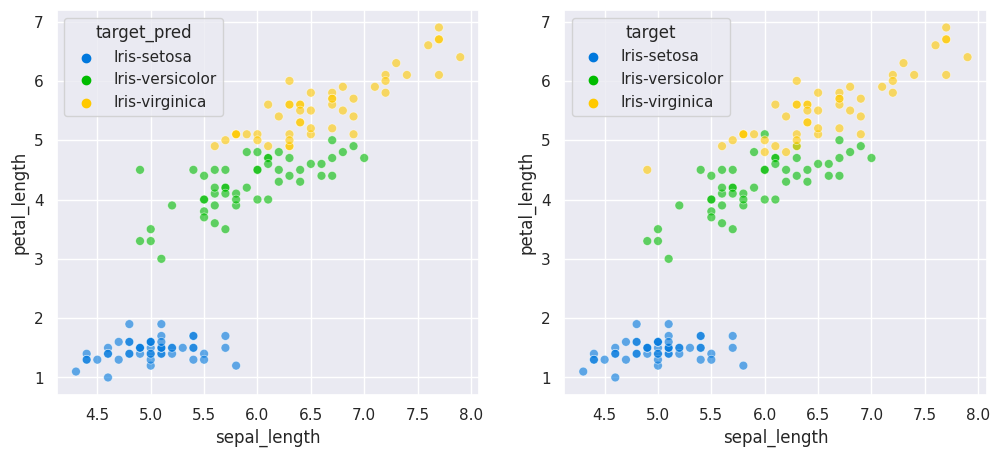

In [143]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.scatterplot(
    x='sepal_length',
    y='petal_length',
    data=df_iris,
    s=40,
    alpha=0.6,
    hue='target_pred',
    palette='nipy_spectral',
    ax=axes[0]
)

sns.scatterplot(
    x='sepal_length',
    y='petal_length',
    data=df_iris,
    s=40,
    alpha=0.6,
    hue='target',
    palette='nipy_spectral',
    ax=axes[1]
)

plt.savefig('assets/sql-for-data-science_02.webp', bbox_inches='tight')

![SQL in Data Science](./assets/sql-for-data-science_02.webp)

## K-means Clustering

In [158]:
query = f'''
WITH points AS
   (SELECT
       index,
       POINT(sepal_length, petal_length) AS xy
    FROM
       iris
    ),

initial AS
   (SELECT 
       RANK() OVER (
          ORDER BY random() 
       ) AS cluster,
       xy
    FROM points
    -- set k=3 since we know there are 3 classes
    LIMIT 3
    ),

iteration AS
   (WITH RECURSIVE kmeans(iter, index, cluster, avg_point) AS (
       SELECT
          1,
          NULL::INTEGER,
          *
        FROM 
           initial
        UNION ALL
        SELECT
           iter + 1,
           index,
           cluster,
           midpoint
        FROM (
           SELECT DISTINCT ON(iter, index)
              *
           FROM (
              SELECT
                 iter,
                 cluster,
                 p.index, 
                 p.xy <-> k.avg_point AS distance,
                 @@ LSEG(p.xy, k.avg_point) AS midpoint,
                 p.xy,
                 k.avg_point
               FROM points p
               CROSS JOIN kmeans k
               ) d
            ORDER BY 1, 3, 4
            ) r
       WHERE iter < 1000
   )
   SELECT
      *
   FROM
      kmeans
   )

SELECT
   k.*,
   cluster
FROM
   iteration i
JOIN
   iris k
USING(index)
WHERE
   iter = 1000
ORDER BY 4,1 ASC ;
'''

In [151]:
def k_means(query):
    conn = None
    try:
        params = config()
        conn = psycopg2.connect(**params)
        cursor = conn.cursor()
        query = query
        cursor.execute(query)
        results = cursor.fetchall()

        cursor.close()
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            return(results)
            conn.close()

In [159]:
# run training with k=3 / max_iter=1000
results = k_nearest_neighbours(query=query)

In [160]:
df_pred = pd.DataFrame(results, columns=['index', 'sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'target', 'target_pred'])
df_pred.head()

,index,sepal_length,sepal_width,petal_length,petal_width,target,target_pred
0,22,4.6,3.6,1.0,0.2,Iris-setosa,2
1,13,4.3,3.0,1.1,0.1,Iris-setosa,2
2,14,5.8,4.0,1.2,0.2,Iris-setosa,2
3,35,5.0,3.2,1.2,0.2,Iris-setosa,2
4,2,4.7,3.2,1.3,0.2,Iris-setosa,2


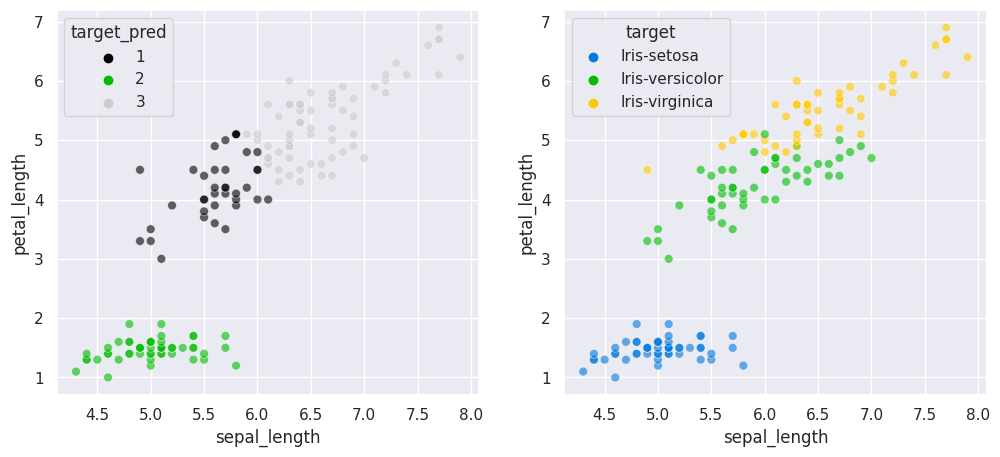

In [161]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.scatterplot(
    x='sepal_length',
    y='petal_length',
    data=df_pred,
    s=40,
    alpha=0.6,
    hue='target_pred',
    palette='nipy_spectral',
    ax=axes[0]
)

sns.scatterplot(
    x='sepal_length',
    y='petal_length',
    data=df_pred,
    s=40,
    alpha=0.6,
    hue='target',
    palette='nipy_spectral',
    ax=axes[1]
)

plt.savefig('assets/sql-for-data-science_03.webp', bbox_inches='tight')

![SQL in Data Science](./assets/sql-for-data-science_03.webp)

## Dataset II

In [162]:
!wget https://github.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/raw/master/spam.csv

--2023-07-02 22:59:04--  https://github.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/raw/master/spam.csv
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv [following]
--2023-07-02 22:59:06--  https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/plain]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K   924KB/s    in 0.5s

In [187]:
data_spam = pd.read_csv ('spam_dataset.csv')   
df_spam = pd.DataFrame(data_spam)
df_spam = df_spam.reset_index()
df_spam.head(5)

,index,cat,sms
0,0,ham,Go until jurong point crazy.. Available only i...
1,1,ham,Ok lar... Joking wif u oni...
2,2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,3,ham,U dun say so early hor... U c already then say...
4,4,ham,Nah I don't think he goes to usf he lives arou...


| index | cat | sms |
| -- | -- | -- |
| 0 | ham | Go until jurong point crazy.. Available only i... |
| 1 | ham | Ok lar... Joking wif u oni... |
| 2 | spam | Free entry in 2 a wkly comp to win FA Cup fina... |
| 3 | ham | U dun say so early hor... U c already then say... |
| 4 | ham | Nah I don't think he goes to usf he lives arou... |

In [191]:
def create_table():
    conn = None
    try:
        # read database configuration
        params = config()
        # connect to the PostgreSQL database
        conn = psycopg2.connect(**params)
        # create a new cursor
        cursor = conn.cursor()
        # create the table
        cursor.execute('''
        CREATE TABLE spam (
            index SMALLINT primary key,
            cat VARCHAR,
            sms VARCHAR
            )
               ''')
        conn.commit()
        # Close communication with the PostgreSQL database
        cursor.close()
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)

In [192]:
def add_data():
    conn = None
    try:
        # read database configuration
        params = config()
        # connect to the PostgreSQL database
        conn = psycopg2.connect(**params)
        # create a new cursor
        cursor = conn.cursor()
        # insert data
        for row in df_spam.itertuples():
            cursor.execute('''
                INSERT INTO spam (
                    index, cat, sms
                ) VALUES (
                    %s, %s, %s
                    )''',
                (
                    row.index,
                    row.cat,
                    row.sms
                )
            )
        # Commit the changes to the database
        conn.commit()
        # Close communication with the PostgreSQL database
        cursor.close()
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)

In [193]:
create_table()
add_data()

## Naive Bayes Classification

In [197]:
query = f'''
-- CTE to create one row per word
WITH staging AS
  (SELECT 
      REGEXP_SPLIT_TO_TABLE(
         LOWER(sms), '[^a-z]+') AS word,
      cat
   FROM
      spam
   WHERE
      cat IS NOT NULL
  ),

-- testing data
test AS
  (SELECT
      index,
      sms
   FROM
      spam
   WHERE
      cat is NOT NULL
  ),
          
-- one row per word + cat
cartesian AS
  (SELECT
      *
   FROM
     (SELECT
         DISTINCT word
      FROM
         staging) w
      CROSS JOIN
     (SELECT
         DISTINCT cat
      FROM
         staging) c
      WHERE
         length(word) > 0
   ),

-- CTE of smoothed frequencies of each word by cat
frequencies AS
  (SELECT
      c.word,
      c.cat,
      -- numerator plus one
      (SELECT
          count(*)+1
       FROM
          staging s
       WHERE
          s.word = c.word
       AND
          s.cat = c.cat) /
      -- denominator plus two
      (SELECT
          count(*)+2
       FROM
          staging s1
       WHERE
          s1.cat = c.cat) ::DECIMAL AS freq
   FROM
      cartesian c
   ),

-- for each row in testing, get the probabilities   
probabilities AS
  (SELECT
      t.index,
      f.cat,
      SUM(LN(f.freq)) AS probability
   FROM
     (SELECT
         index,
         REGEXP_SPLIT_TO_TABLE(
            LOWER(sms), '[^a-z]+') AS word
      FROM
         test) t
   JOIN
     (SELECT
         word,
         cat,
         freq
      FROM
         frequencies) f 
   ON t.word = f.word
   GROUP BY 1, 2
  )

-- keep only the highest estimate            
SELECT
   sms,
   probabilities.cat
FROM
   probabilities
JOIN
  (SELECT
      index,
      max(probability) AS max_probability
   FROM
      probabilities
   GROUP BY 1) p
ON probabilities.index = p.index
AND probabilities.probability = p.max_probability
JOIN
   test
ON probabilities.index = test.index
ORDER BY 1 ;
'''

In [195]:
def naive_bayes(query):
    conn = None
    try:
        params = config()
        conn = psycopg2.connect(**params)
        cursor = conn.cursor()
        query = query
        cursor.execute(query)
        results = cursor.fetchall()

        cursor.close()
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            return(results)
            conn.close()

In [198]:
# buckle up....this will take a while
results = naive_bayes(query=query)

In [211]:
df_pred = pd.DataFrame(results, columns=['message', 'cat_pred'])
df_pred[df_pred['cat_pred'] == 'ham'].head(25)

,message,cat_pred
0,all write or wat..,ham
1,bot notes oredi... Cos i juz rem i got...,ham
2,called dad oredi...,ham
3,collecting ur laptop then going to configu...,ham
4,come lt 25 n pass to me lar,ham
5,comin to fetch us oredi...,ham
6,dun need to pick ur gf?,ham
7,dun wan to watch infernal affair?,ham
8,eatin later but i'm eatin wif my frens now...,ham
9,give me some time to walk there.,ham


|  | message | cat_pred |
| -- | -- | -- |
| 0 | all write or wat.. | ham |
| 1 | bot notes oredi... Cos i juz rem i got... | ham |
| 2 | called dad oredi... | ham |
| 3 | collecting ur laptop then going to configu... | ham |
| 4 | come lt 25 n pass to me lar | ham |
| 5 | comin to fetch us oredi... | ham |
| 6 | dun need to pick ur gf? | ham |
| 7 | dun wan to watch infernal affair? | ham |
| 8 | eatin later but i'm eatin wif my frens now... | ham |
| 9 | give me some time to walk there. | ham |
| 10 | go home liao? Ask dad to pick me up at 6... | ham |
| 11 | got wat to buy tell us then _ no need to... | ham |
| 12 | log off 4 wat. It's sdryb8i | ham |
| 13 | mean it's confirmed... I tot they juz say ... | ham |
| 14 | neva tell me how i noe... I'm not at home ... | ham |
| 15 | no home work to do meh... | ham |
| 16 | only send me the contents page... | ham |
| 17 | predict wat time _'ll finish buying? | ham |
| 18 | ready then call me... | ham |
| 19 | say until like dat i dun buy ericsson oso ... | ham |
| 20 | still attending da talks? | ham |
| 21 | still got lessons? in sch? | ham |
| 23 | thk of wat to eat tonight. | ham |
| 24 | v ma fan... | ham |
| 25 | wait 4 me in sch i finish ard 5.. | ham |

In [210]:
df_pred[df_pred['cat_pred'] == 'spam'].head(25)

,message,cat_pred
22,takin linear algebra today?,spam
34,and picking them up from various points,spam
53,(Bank of Granite issues Strong-Buy) EXPLOSIVE ...,spam
60,* FREE* POLYPHONIC RINGTONE Text SUPER to 8713...,spam
68,**FREE MESSAGE**Thanks for using the Auction S...,spam
70,+123 Congratulations - in this week's competit...,spam
71,+123 Congratulations - in this week's competit...,spam
72,+449071512431 URGENT! This is the 2nd attempt ...,spam
73,-PLS STOP bootydelious (32/F) is inviting you ...,spam
77,07732584351 - Rodger Burns - MSG = We tried to...,spam


|  | message | cat_pred |
| -- | -- | -- |
| 22 | takin linear algebra today? | spam |
| 34 | and picking them up from various points | spam |
| 53 | (Bank of Granite issues Strong-Buy) EXPLOSIVE ... | spam |
| 60 | * FREE* POLYPHONIC RINGTONE Text SUPER to 8713... | spam |
| 68 | **FREE MESSAGE**Thanks for using the Auction S... | spam |
| 70 | +123 Congratulations - in this week's competit... | spam |
| 71 | +123 Congratulations - in this week's competit... | spam |
| 72 | +449071512431 URGENT! This is the 2nd attempt ... | spam |
| 73 | -PLS STOP bootydelious (32/F) is inviting you ... | spam |
| 77 | 07732584351 - Rodger Burns - MSG = We tried to... | spam |
| 78 | 08714712388 between 10am-7pm Cost 10p | spam |
| 79 | 09066362231 URGENT! Your mobile No 07xxxxxxxxx... | spam |
| 80 | 0A$NETWORKS allow companies to bill for SMS so... | spam |
| 91 | 100 dating service cal;l 09064012103 box334sk38ch | spam |
| 92 | 1000's flirting NOW! Txt GIRL or BLOKE & ur NA... | spam |
| 93 | 1000's of girls many local 2 u who r virgins 2... | spam |
| 94 | 18 days to Euro2004 kickoff! U will be kept in... | spam |
| 95 | 18 days to Euro2004 kickoff! U will be kept in... | spam |
| 96 | 1Apple/Day=No Doctor. 1Tulsi Leaf/Day=No Cance... | spam |
| 97 | 1st wk FREE! Gr8 tones str8 2 u each wk. Txt N... | spam |
| 101 | 2/2 146tf150p | spam |
| 102 | 22 days to kick off! For Euro2004 U will be ke... | spam |
| 103 | 25p 4 alfie Moon's Children in need song on ur... | spam |
| 104 | 26th OF JULY | spam |
| 107 | 2p per min to call Germany 08448350055 from yo... | spam |